In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score



In [2]:
tranform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = datasets.ImageFolder(root=r"D:\data_dow\vgg16\crop_images_resize", transform=tranform)
dataset_size = len(dataset)
ind = list(range(dataset_size))

numclass = len(dataset.classes)
print(f"numclass : {numclass} - class : {dataset.classes}")


numclass : 3 - class : ['bus', 'car', 'truck']


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision import models
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(ind)):
    print(f"\n Fold {fold+1}/{k_folds} ")
    
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    
    train_labels = [dataset.targets[i] for i in train_idx]
    class_counts = np.bincount(train_labels)
    weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = [weights[label] for label in train_labels]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_subset, batch_size=32, sampler=sampler)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    model = models.vgg16(pretrained=True)
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, numclass)  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    num_epochs = 5  
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = 100.0 * correct / total
        model.eval()
        val_loss = 0.0
        val_correct, val_total = 0, 0
        all_labels, all_preds = [], []
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Val"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = 100.0 * val_correct / val_total
        print(f" Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f" Epoch [{epoch+1}/{num_epochs}] - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"\nFold {fold+1} - Final Validation Accuracy: {val_acc:.2f}%")
    print(f" Precision: {precision:.4f} - Recall: {recall:.4f} - F1-score: {f1:.4f}\n")



 Fold 1/5 


c:\Users\Duong\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Duong\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5 - Val: 100%|██████████| 969/969 [08:09<00:00,  1.98it/s]


 Epoch [1/5] - Train Loss: 0.2497, Train Acc: 90.72%
 Epoch [1/5] - Val Loss: 0.2473, Val Acc: 91.90%


Epoch 2/5 - Val: 100%|██████████| 969/969 [05:18<00:00,  3.04it/s]


 Epoch [2/5] - Train Loss: 0.0970, Train Acc: 96.73%
 Epoch [2/5] - Val Loss: 0.2520, Val Acc: 92.00%


Epoch 3/5 - Val: 100%|██████████| 969/969 [08:08<00:00,  1.98it/s]


 Epoch [3/5] - Train Loss: 0.0704, Train Acc: 97.67%
 Epoch [3/5] - Val Loss: 0.2447, Val Acc: 92.48%


Epoch 4/5 - Val: 100%|██████████| 969/969 [05:18<00:00,  3.05it/s]


 Epoch [4/5] - Train Loss: 0.0569, Train Acc: 98.17%
 Epoch [4/5] - Val Loss: 0.3434, Val Acc: 90.97%


Epoch 5/5 - Val: 100%|██████████| 969/969 [08:10<00:00,  1.98it/s]


 Epoch [5/5] - Train Loss: 0.0505, Train Acc: 98.36%
 Epoch [5/5] - Val Loss: 0.3482, Val Acc: 91.29%

Fold 1 - Final Validation Accuracy: 91.29%
 Precision: 0.9453 - Recall: 0.9129 - F1-score: 0.9245


 Fold 2/5 


c:\Users\Duong\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Duong\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5 - Val: 100%|██████████| 969/969 [07:15<00:00,  2.23it/s]


 Epoch [1/5] - Train Loss: 0.2620, Train Acc: 90.13%
 Epoch [1/5] - Val Loss: 0.2380, Val Acc: 92.97%


Epoch 2/5 - Val: 100%|██████████| 969/969 [05:17<00:00,  3.05it/s]


 Epoch [2/5] - Train Loss: 0.0979, Train Acc: 96.73%
 Epoch [2/5] - Val Loss: 0.2596, Val Acc: 93.57%


Epoch 3/5 - Val: 100%|██████████| 969/969 [05:19<00:00,  3.04it/s]


 Epoch [3/5] - Train Loss: 0.0705, Train Acc: 97.71%
 Epoch [3/5] - Val Loss: 0.2830, Val Acc: 92.51%


Epoch 4/5 - Val: 100%|██████████| 969/969 [05:19<00:00,  3.04it/s]


 Epoch [4/5] - Train Loss: 0.0570, Train Acc: 98.14%
 Epoch [4/5] - Val Loss: 0.2337, Val Acc: 93.92%


Epoch 5/5 - Val: 100%|██████████| 969/969 [05:18<00:00,  3.04it/s]


 Epoch [5/5] - Train Loss: 0.0479, Train Acc: 98.44%
 Epoch [5/5] - Val Loss: 0.2474, Val Acc: 94.32%

Fold 2 - Final Validation Accuracy: 94.32%
 Precision: 0.9515 - Recall: 0.9432 - F1-score: 0.9460


 Fold 3/5 


c:\Users\Duong\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Duong\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5 - Val: 100%|██████████| 969/969 [05:43<00:00,  2.82it/s]


 Epoch [1/5] - Train Loss: 0.2655, Train Acc: 89.98%
 Epoch [1/5] - Val Loss: 0.2130, Val Acc: 92.72%


Epoch 2/5 - Val: 100%|██████████| 969/969 [05:19<00:00,  3.04it/s]


 Epoch [2/5] - Train Loss: 0.0989, Train Acc: 96.61%
 Epoch [2/5] - Val Loss: 0.3324, Val Acc: 90.06%


Epoch 3/5 - Val: 100%|██████████| 969/969 [08:06<00:00,  1.99it/s]


 Epoch [3/5] - Train Loss: 0.0707, Train Acc: 97.69%
 Epoch [3/5] - Val Loss: 0.2436, Val Acc: 94.18%


Epoch 4/5 - Val: 100%|██████████| 969/969 [05:20<00:00,  3.02it/s]


 Epoch [4/5] - Train Loss: 0.0577, Train Acc: 98.17%
 Epoch [4/5] - Val Loss: 0.3356, Val Acc: 92.01%


Epoch 5/5 - Val: 100%|██████████| 969/969 [05:21<00:00,  3.02it/s]


 Epoch [5/5] - Train Loss: 0.0502, Train Acc: 98.42%
 Epoch [5/5] - Val Loss: 0.3061, Val Acc: 93.52%

Fold 3 - Final Validation Accuracy: 93.52%
 Precision: 0.9505 - Recall: 0.9352 - F1-score: 0.9410


 Fold 4/5 


c:\Users\Duong\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Duong\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5 - Val: 100%|██████████| 969/969 [06:18<00:00,  2.56it/s]


 Epoch [1/5] - Train Loss: 0.2576, Train Acc: 90.43%
 Epoch [1/5] - Val Loss: 0.2236, Val Acc: 93.02%


Epoch 2/5 - Val: 100%|██████████| 969/969 [05:20<00:00,  3.03it/s]


 Epoch [2/5] - Train Loss: 0.0985, Train Acc: 96.70%
 Epoch [2/5] - Val Loss: 0.2517, Val Acc: 94.26%


Epoch 3/5 - Val: 100%|██████████| 969/969 [05:20<00:00,  3.03it/s]


 Epoch [3/5] - Train Loss: 0.0713, Train Acc: 97.66%
 Epoch [3/5] - Val Loss: 0.2334, Val Acc: 95.22%


Epoch 4/5 - Val: 100%|██████████| 969/969 [05:20<00:00,  3.03it/s]


 Epoch [4/5] - Train Loss: 0.0598, Train Acc: 98.09%
 Epoch [4/5] - Val Loss: 0.2654, Val Acc: 93.86%


Epoch 5/5 - Val: 100%|██████████| 969/969 [05:19<00:00,  3.03it/s]


 Epoch [5/5] - Train Loss: 0.0502, Train Acc: 98.40%
 Epoch [5/5] - Val Loss: 0.2427, Val Acc: 94.67%

Fold 4 - Final Validation Accuracy: 94.67%
 Precision: 0.9517 - Recall: 0.9467 - F1-score: 0.9488


 Fold 5/5 


c:\Users\Duong\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Duong\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5 - Val: 100%|██████████| 969/969 [05:29<00:00,  2.94it/s]


 Epoch [1/5] - Train Loss: 0.2615, Train Acc: 90.16%
 Epoch [1/5] - Val Loss: 0.2765, Val Acc: 90.39%


Epoch 2/5 - Val: 100%|██████████| 969/969 [05:21<00:00,  3.02it/s]


 Epoch [2/5] - Train Loss: 0.0977, Train Acc: 96.70%
 Epoch [2/5] - Val Loss: 0.1883, Val Acc: 94.79%


Epoch 3/5 - Val: 100%|██████████| 969/969 [05:21<00:00,  3.01it/s]


 Epoch [3/5] - Train Loss: 0.0730, Train Acc: 97.58%
 Epoch [3/5] - Val Loss: 0.2058, Val Acc: 94.59%


Epoch 4/5 - Val: 100%|██████████| 969/969 [07:48<00:00,  2.07it/s]


 Epoch [4/5] - Train Loss: 0.0573, Train Acc: 98.14%
 Epoch [4/5] - Val Loss: 0.2647, Val Acc: 93.50%


Epoch 5/5 - Val: 100%|██████████| 969/969 [05:21<00:00,  3.02it/s]


 Epoch [5/5] - Train Loss: 0.0494, Train Acc: 98.48%
 Epoch [5/5] - Val Loss: 0.2390, Val Acc: 94.15%

Fold 5 - Final Validation Accuracy: 94.15%
 Precision: 0.9523 - Recall: 0.9415 - F1-score: 0.9455



In [4]:
torch.save(model.state_dict(), f"vgg16_kfold.pth")
print(" Mô hình đã được lưu!")


 Mô hình đã được lưu!


In [1]:
import torch
import torchvision.models as models
import torch.nn as nn

model = models.vgg16(pretrained=False)  
model.classifier[6] = nn.Linear(4096, 3)
model.load_state_dict(torch.load("vgg16_kfold.pth"))
model.eval()
print("Mô hình đã được tải thành công")


c:\Users\Duong\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Duong\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Mô hình đã được tải thành công


c:\Users\Duong\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Duong\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


bus: 0.9606
car: 0.0341
truck: 0.0053

 Dự đoán: bus (Xác suất: 0.9606)


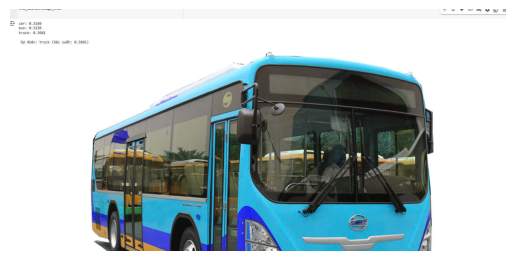

In [4]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt



model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(4096, 3)
model.load_state_dict(torch.load("vgg16_kfold.pth")) 
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

image_path = r"C:\Users\Duong\Downloads\z6452211773435_c7f80d414bb395f26a2234e8564203e8.jpg"
image = Image.open(image_path).convert("RGB")  
input_tensor = transform(image).unsqueeze(0) 

with torch.no_grad():
    output = model(input_tensor)

probabilities = torch.nn.functional.softmax(output, dim=1)[0]  

class_names = ["bus", "car", "truck"]
predicted_class = output.argmax(dim=1).item()

for i, (label, prob) in enumerate(zip(class_names, probabilities.numpy())):
    print(f"{label}: {prob:.4f}")  

print(f"\n Dự đoán: {class_names[predicted_class]} (Xác suất: {probabilities[predicted_class]:.4f})")

plt.imshow(cv2.imread(image_path))
plt.axis('off')
plt.show()
